# Rede do comércio mundial e crises econômicas

### Alunos:
- Arthur Santorum Lorenzetto - 12559465  
- Eduardo Zaffari Monteiro - 12559490  
- Pedro Henrique de Freitas Maçonetto - 12675419  

Este notebook tem como objetivo demonstrar como a rede de comércio mundial é influênciada por crises econômicas.

Ao longo do projeto serão demonstradas três formas diferentes de se utilizar a rede, e suas respectivas medidas que auxiliará na análise do problema.

## Bibliotecas a serem utilizadas

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt

## Lendo as redes de comércio mundial por ano

In [3]:
df = pd.read_csv('trade_1988_2021.csv')
df.dropna(inplace=True)
df.head()

,ReporterISO3,ReporterName,PartnerISO3,PartnerName,Year,TradeFlowName,TradeValue in 1000 USD
0,AFG,Afghanistan,SWE,Sweden,2017,Export,86.752
1,AFG,Afghanistan,JOR,Jordan,2018,Export,2796.481
2,AFG,Afghanistan,JOR,Jordan,2017,Export,3100.187
3,AFG,Afghanistan,ITA,Italy,2018,Export,279.918
4,AFG,Afghanistan,ITA,Italy,2017,Export,416.642


## Definindo funções

In [4]:
def momment(G,m):
    M = 0
    N = len(G)
    for i in G.nodes:
        M = M + G.degree(i)**m
    M = M/N
    return M
def degree_distribution(G):
    vk = dict(G.degree())
    vk = list(vk.values())  # we get only the degree values
    vk = np.array(vk)
    maxk = np.max(vk)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    return kvalues,Pk

def shannon_entropy(G):
    k,Pk = degree_distribution(G)
    H = 0
    for p in Pk:
        if(p > 0):
            H = H - p*math.log(p, 2)
    return H

## Criando um arquivo para cada ano da rede 

In [ ]:
for year in df['Year'].unique():
    dfyear = df[df['Year'] == year]
    dfyear[['ReporterISO3', 'PartnerISO3', 'TradeValue in 1000 USD']].to_csv(f'RedesAnos/{year}.txt', sep=' ', index=False, header=False)

## Lendo e mostrando uma rede de exemplo

In [5]:
G = nx.read_edgelist('RedesAnos/2020.txt',data=(("weight", float),))

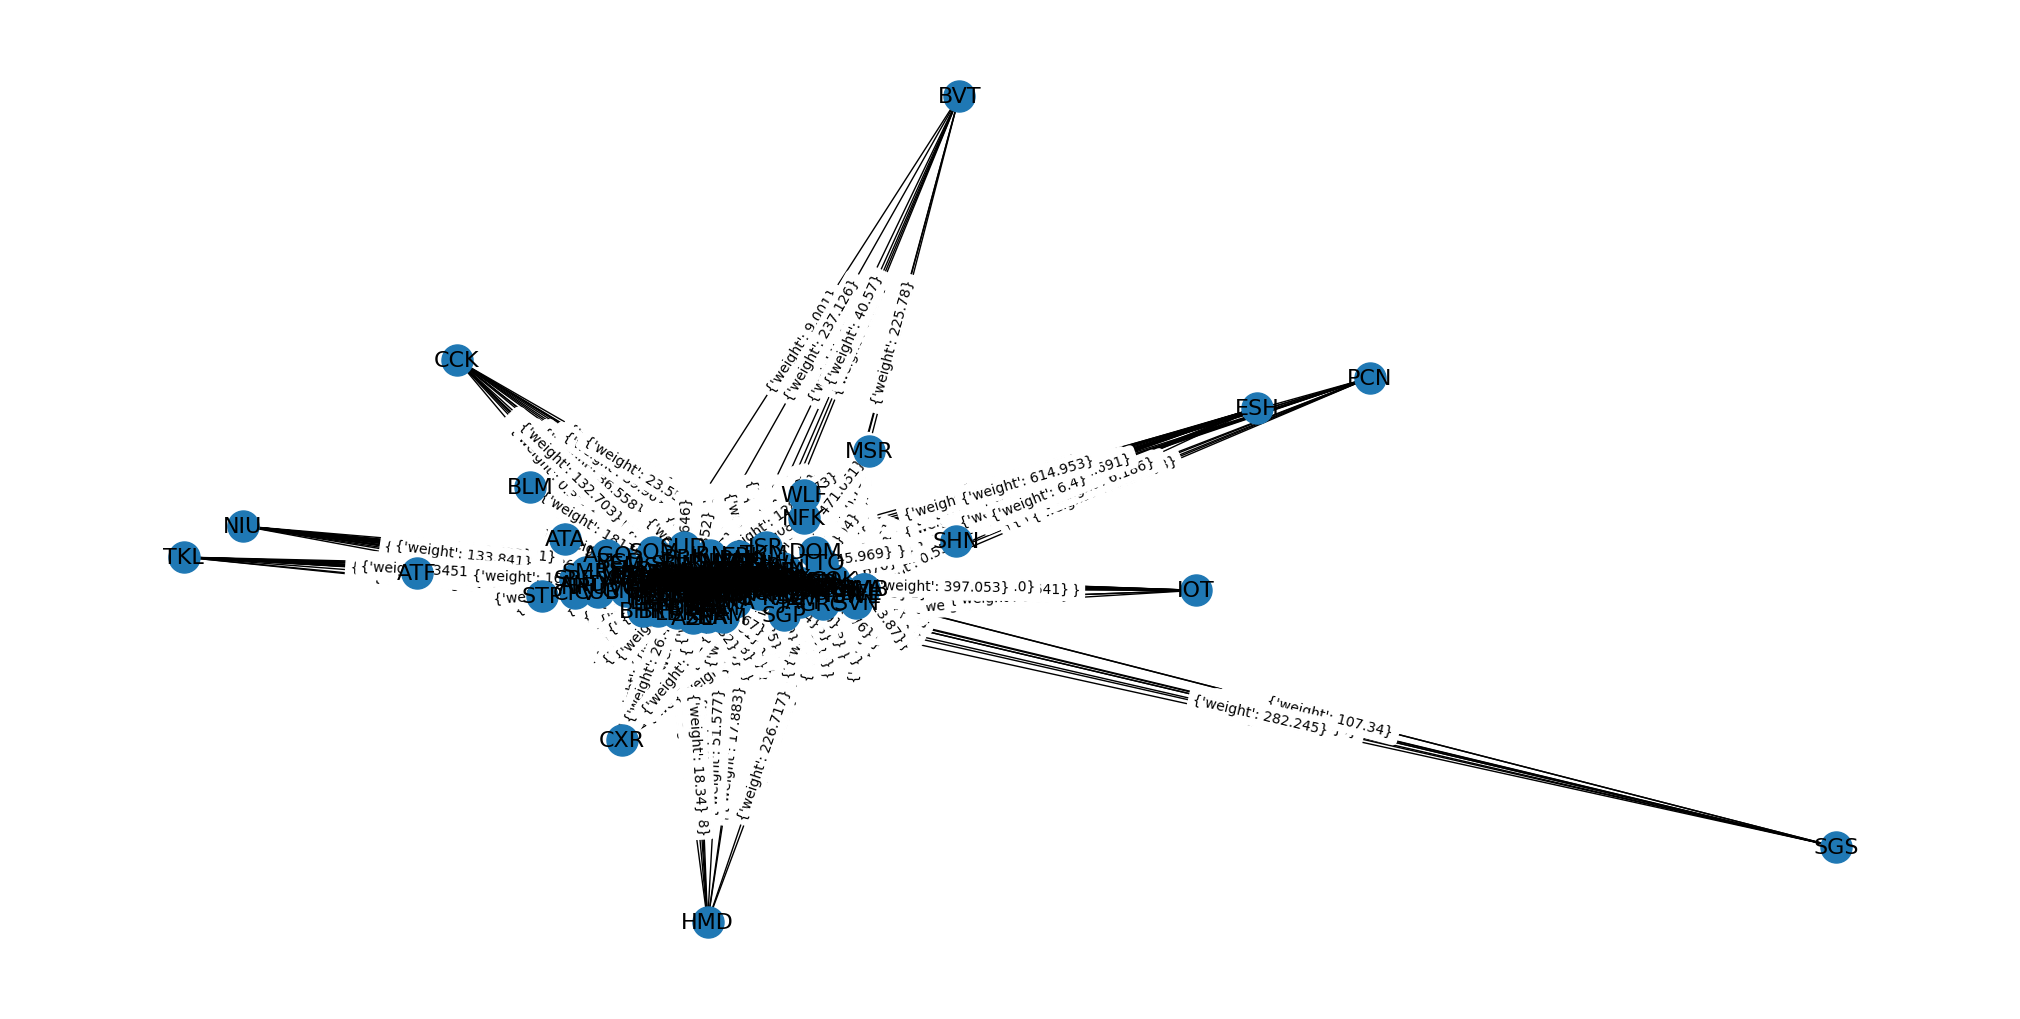

In [6]:
import matplotlib.pyplot as plt


pos=nx.fruchterman_reingold_layout(G)
plt.figure(figsize=(20, 10))
nx.draw(G, with_labels = True, node_size=500, font_size=16, pos = pos)
nx.draw_networkx_edge_labels(G, pos = pos)
plt.show()

## Removendo a metade inferior das conexões durante todo o período
Isso é feito de forma a evitar a exploração de conexões pouco relevantes,
ou seja, que no contexto do problema representam trocas comerciais de valor baixo. Isso se mostrou necessário
pois a maioria das crises apenas reduz o peso das conexões, e não a elimina por inteiro, portanto sem esse tratamento
não é possível identificar as crises economicas que ocorreram no período.

In [7]:
weights = []
for year in np.sort(df['Year'].unique()):
    G = nx.read_edgelist(f'RedesAnos/{year}.txt',data=(("weight", float),))
    for (u,v,w) in G.edges(data=True):
        weights.append(w['weight'])


min_weight = np.median(weights)
print(min_weight)

# min_weight = 30000
G = nx.read_edgelist('RedesAnos/2020.txt',data=(("weight", float),))
Gnew = nx.Graph()
for (u,v,w) in G.edges(data=True):
    if w['weight'] > min_weight :
        Gnew.add_edge(u, v, weight=1)
G = Gnew

1871.0565


## Exibindo rede de exemplo após remoção de conexões de pouco valor

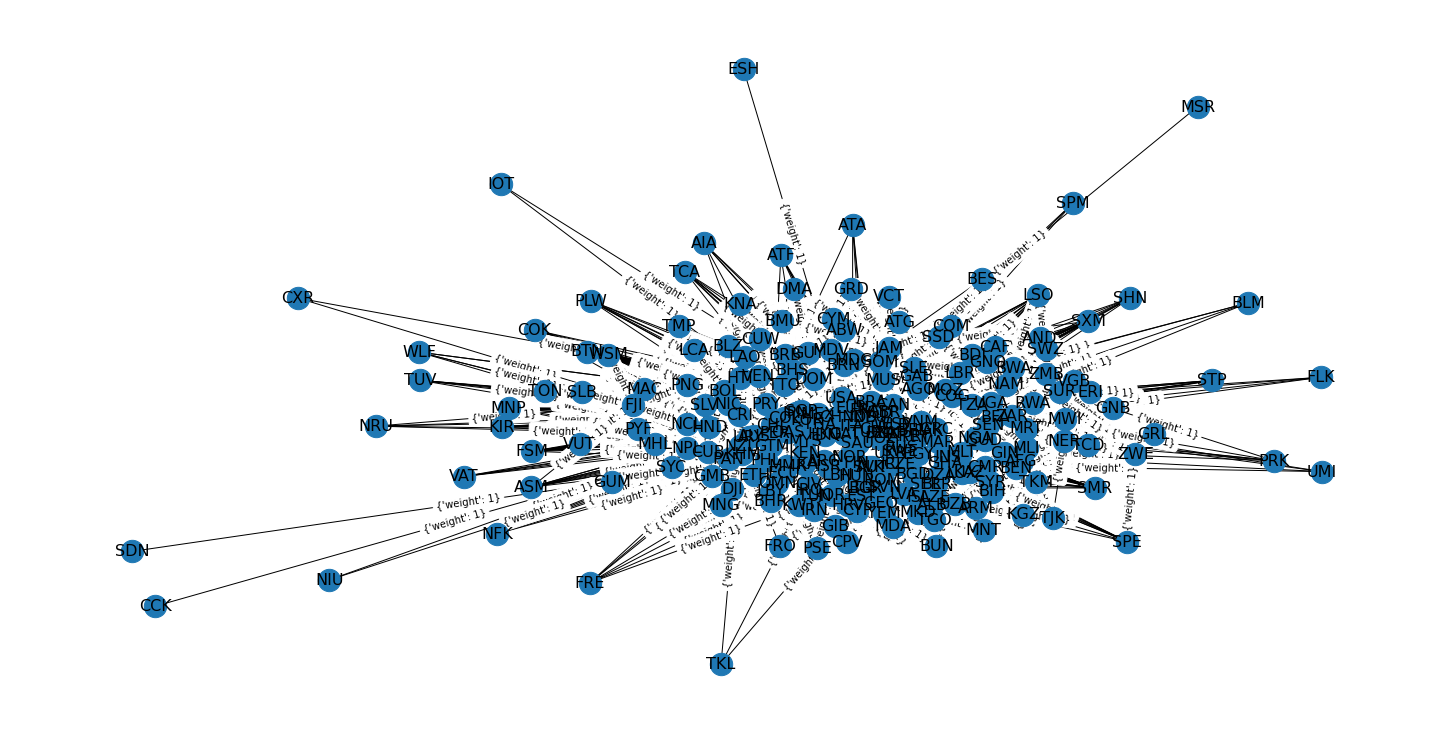

In [ ]:
import matplotlib.pyplot as plt

pos=nx.fruchterman_reingold_layout(G)
plt.figure(figsize=(20, 10))
nx.draw(G, with_labels = True, node_size=500, font_size=16, pos = pos)
nx.draw_networkx_edge_labels(G, pos = pos)
plt.show()

## Calcular medidas por ano: 
average shortest path length, entropia do grau, média do eigenvector centrality, modularidade etc.

### Rede Padrão

In [8]:
result = pd.DataFrame(columns = ['Grau Medio', 'Entropia', 'Menor caminho medio', 'Eigenvector centrality', 'Assortatividade', 'Modularidade', 'Closeness centrality', 'Eficiencia Global'])
medidas = []

for year in np.sort(df['Year'].unique()):

    G = nx.read_edgelist(f'RedesAnos/{year}.txt',data=(("weight", float),))
    
    avg_dg = momment(G, 1)
    entropy = shannon_entropy(G)
    short_path = nx.average_shortest_path_length(G)
    eign_mean = np.mean(list(dict(nx.eigenvector_centrality(G)).values()))
    assortativity = nx.degree_assortativity_coefficient(G)
    lc = nx.community.louvain_communities(G)
    mod = nx.community.modularity(G, lc)
    close = np.mean(list(dict(nx.closeness_centrality(G)).values()))
    ef = nx.global_efficiency(G)
    
    meds = [avg_dg, entropy, short_path, eign_mean, assortativity, mod, close, ef]
    
    result.loc[year] = meds

### Rede com Mediana

In [9]:
result_med = pd.DataFrame(columns = ['Grau Medio', 'Entropia', 'Menor caminho medio', 'Eigenvector centrality', 'Assortatividade', 'Modularidade', 'Closeness centrality', 'Eficiencia Global'])
medidas = []

for year in np.sort(df['Year'].unique()):

    G = nx.read_edgelist(f'RedesAnos/{year}.txt',data=(("weight", float),))
    Gnew = nx.Graph()
    
    for (u,v,w) in G.edges(data=True):
        if w['weight'] > min_weight :
            Gnew.add_edge(u, v, weight=1)
    G = Gnew
    
    avg_dg = momment(G, 1)
    entropy = shannon_entropy(G)
    short_path = nx.average_shortest_path_length(G)
    eign_mean = np.mean(list(dict(nx.eigenvector_centrality(G)).values()))
    assortativity = nx.degree_assortativity_coefficient(G)
    lc = nx.community.louvain_communities(G)
    mod = nx.community.modularity(G, lc)
    close = np.mean(list(dict(nx.closeness_centrality(G)).values()))
    ef = nx.global_efficiency(G)
    
    meds = [avg_dg, entropy, short_path, eign_mean, assortativity, mod, close, ef]
    
    result_med.loc[year] = meds

### Rede Personalizada

Alteração da rede por peso de conexão

A seguinte função faz com que a cada ano, cada uma das conexões sejam comparadas com as do ano anterior, e caso tenham decaido um certo percentual a conexão é removida. 

Este procedimento é feito para os casos em que utilizamos majoritariamente medidas que levam em consideração as conexões e nãos os pesos.

Podemos recuperar uma conexão se ela ultrapassar seu percentual de perda original. Para evitar de perdermos uma conexão para sempre, com o passar dos anos o percentual é diminuido por uma certa taxa de recuperação.

In [10]:

def redutor_vertices(lost_rate = 0.5, recover_rate = 0.05):
    # Instanciando variáveis a serem utilizadas
    result = pd.DataFrame(columns = ['Grau Medio', 'Entropia', 'Menor caminho medio', 'Eigenvector centrality', 'Assortatividade', 'Modularidade', 'Closeness centrality', 'Diametro', 'Eficiencia Global'])
    years = np.sort(df['Year'].unique())
    # lostedge deve ser instanciado com np.empty((0, 2)) para garantir algumas propriedades que serão exploradas durante o código
    lostedge = np.empty((0, 2), dtype=object)

    for year in years:
        # Como o primeiro ano não teria antecedente, ele é computado de forma "Pura"
        if year == years[0]:
            G = nx.read_edgelist(f'RedesAnos/{year}.txt',data=(("weight", float),))
            previousYear = G
            Gcc = G
        else:
            
            # Coletando rede do ano atual
            currentYear = nx.read_edgelist(f'RedesAnos/{year}.txt',data=(("weight", float),))
            currentYearEdges = list(map(tuple, np.array(list(currentYear.edges(data=True)), dtype=object)[:, :2]))
            # Tentando recuperar vertices perdidos
            if len(lostedge) > 0:
                # Pegando as conexões em comum entre o ano atual e as que já se perderam
                try_recover = list(set(list(map(tuple, lostedge[:, :1]))) & set(currentYearEdges))
                for j in try_recover:
                    # Buscar o indice da conexão perdida
                    index = next((i for i, x in enumerate(lostedge) if x[0] == j), None)
                    peso = currentYear.get_edge_data(j[0], j[1])['weight']
                    
                    # Se a conexão atual é maior que a anterior, ela se recupera, caso contrario é removida do atual
                    if lostedge[index][1] < peso:
                        lostedge = np.delete(lostedge, index)
                    else:
                        currentYear.remove_edge(j)

            # Coletando conexões do ano anterior
            previousYearEdges = list(map(tuple, np.array(list(previousYear.edges(data=True)))[:, :2]))     
            
            # Pegando as conexões em comum entre o ano atual e o anterior
            simEdges = list(set(previousYearEdges) & set(currentYearEdges))
            
            
            new_lostedge = np.empty((0, 2), dtype=object)
            # Instanciando uma copia do ano atual para eventuais remocoes
            G = currentYear.copy()
            # Definindo os vertices que se manterao e que serao perdidos
            for j in simEdges:
                # Pegando os pesos dos anos 
                peso_anterior = 0 if len(previousYear.get_edge_data(j[0], j[1])) == 0 else previousYear.get_edge_data(j[0], j[1])['weight']
                peso_atual = 0 if len(currentYear.get_edge_data(j[0], j[1])) == 0 else currentYear.get_edge_data(j[0], j[1])['weight']
                
                # Se peso atual e menor que o anterior pela taxa de perda, deve ser removida a conexão
                # Formato de conexão perdida: ((Vértice1, Vértice2), Peso)
                if peso_anterior*lost_rate > peso_atual:
                    new_lostedge = np.concatenate((new_lostedge, np.array([([j, previousYear.get_edge_data(j[0], j[1])['weight']*lost_rate])], dtype=object)), axis=0)
                    G.remove_edge(j[0], j[1])


            # Diminuindo o taxa de recuperacao 
            if len(lostedge) > 0:      
                lostedge[:, 1:] = lostedge[:, 1:]*(1-recover_rate)
                
            # Adicionando as novas perdas às antigas
            if len(new_lostedge) > 0:   
                lostedge = np.concatenate((lostedge, new_lostedge), axis=0)

            # Eventualmente a rede pode ficar segmentada, portanto para analisarmos as medidas deve-se considerar o maior componente apenas, 
            # porém mantendo a rede completa para recuperação das conexões
            Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
            Gcc = G.subgraph(Gcc[0])
            previousYear = G
        
        # Medidas
        avg_dg = momment(Gcc, 1)
        entropy = shannon_entropy(Gcc)
        short_path = nx.average_shortest_path_length(Gcc)
        eign_mean = np.mean(list(dict(nx.eigenvector_centrality(Gcc)).values()))
        assortativity = nx.degree_assortativity_coefficient(Gcc)
        lc = nx.community.louvain_communities(Gcc)
        mod = nx.community.modularity(Gcc, lc)
        close = np.mean(list(dict(nx.closeness_centrality(Gcc)).values()))
        ef = nx.global_efficiency(Gcc)
        
        result.loc[year] = [avg_dg, entropy, short_path, eign_mean, assortativity, mod, close, ef]
    return result

In [11]:
result_pers = redutor_vertices()

## Dataframe com medidas da rede de cada ano

In [28]:
result.head(3)

,Grau Medio,Entropia,Menor caminho medio,Eigenvector centrality,Assortatividade,Modularidade,Closeness centrality,Eficiencia Global
1988,43.404878,4.900872,1.790100,0.059263,-0.756825,0.111953,0.575174,0.605906
1989,57.736585,5.815025,1.721569,0.060570,-0.668560,0.058422,0.600084,0.640746
1990,65.776699,6.210847,1.682501,0.060957,-0.591147,0.060507,0.613568,0.659871


In [26]:
result_med.head(3)

,Grau Medio,Entropia,Menor caminho medio,Eigenvector centrality,Assortatividade,Modularidade,Closeness centrality,Eficiencia Global
1988,27.715736,5.237905,1.896198,0.055672,-0.686408,0.081847,0.536859,0.564436
1989,35.758794,5.795790,1.860667,0.056325,-0.616555,0.113759,0.548887,0.583422
1990,38.700508,5.999204,1.824770,0.057458,-0.552149,0.126334,0.558855,0.595022


In [33]:
result_pers.head(3)

,Grau Medio,Entropia,Menor caminho medio,Eigenvector centrality,Assortatividade,Modularidade,Closeness centrality,Eficiencia Global
1988,43.404878,4.900872,1.790100,0.059263,-0.756825,0.111953,0.575174,0.605906
1989,52.614634,5.905271,1.749880,0.060132,-0.651485,0.052575,0.586643,0.627658
1990,60.048544,6.307372,1.712574,0.060659,-0.571235,0.039941,0.599764,0.645544


## Análise dos resultados

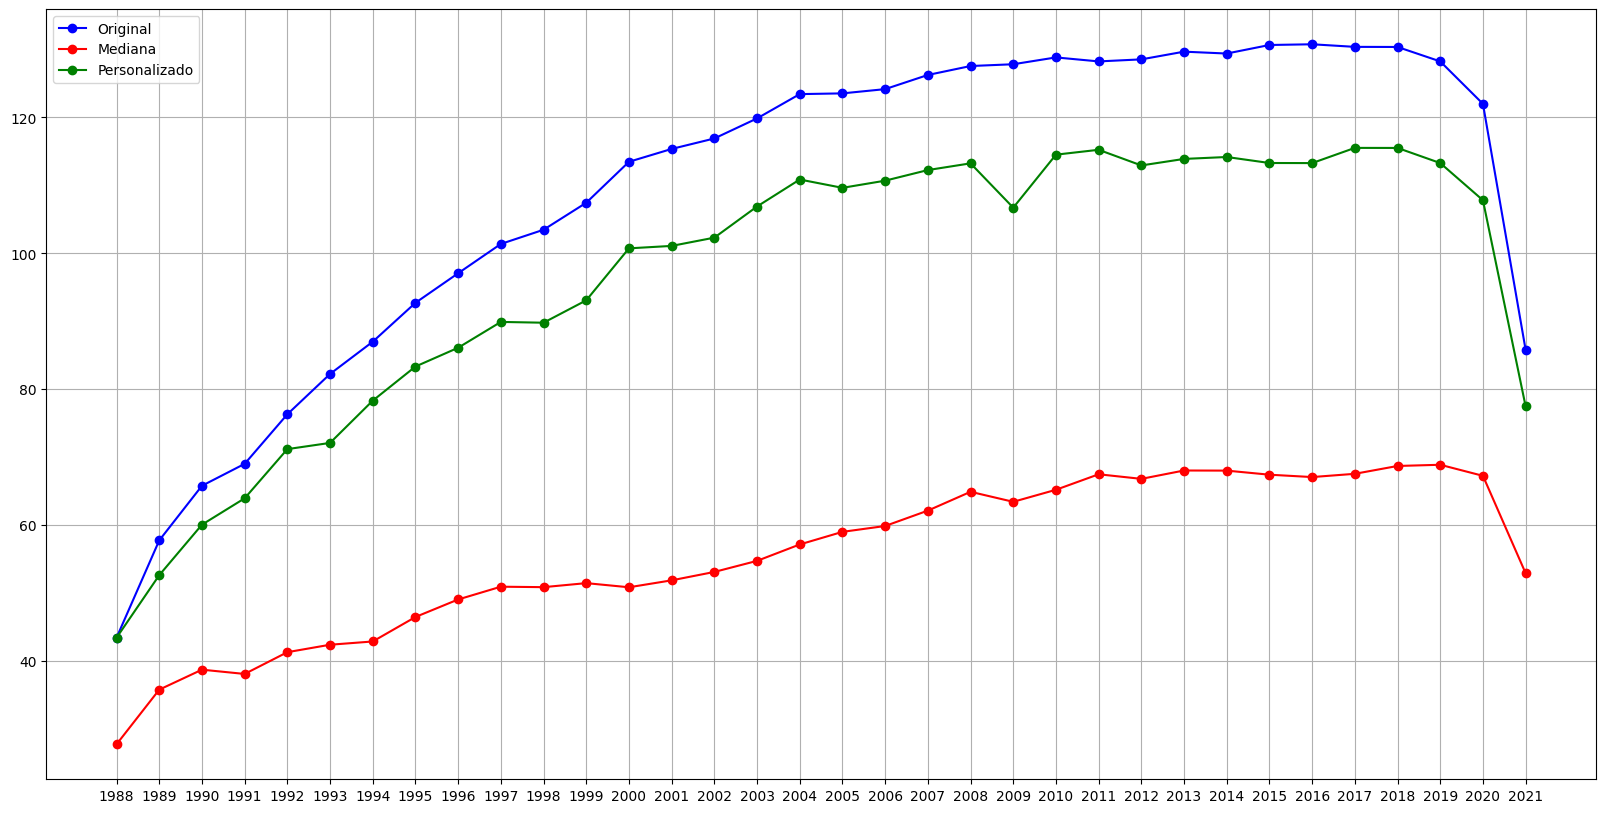

In [18]:
plt.figure(figsize=(20,10))
plt.xticks(df['Year'].unique())
plt.plot(result['Grau Medio'],'-ob', label='Original')
plt.plot(result_med['Grau Medio'],'-or', label='Mediana')
plt.plot(result_pers['Grau Medio'],'-og', label='Personalizado')
plt.legend()
plt.grid(True)
plt.show()

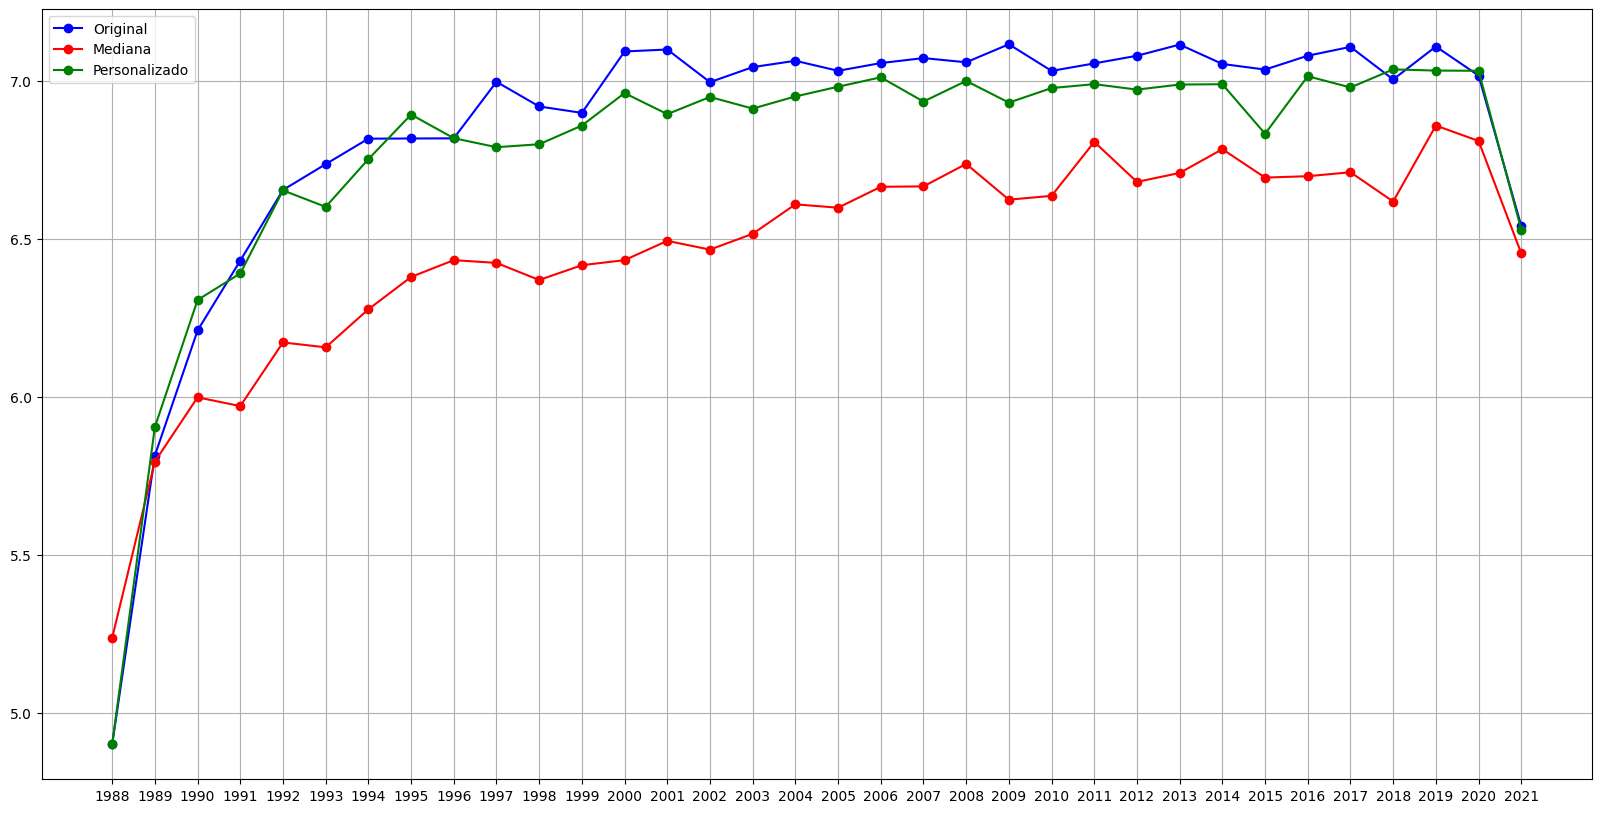

In [19]:
plt.figure(figsize=(20,10))
plt.xticks(df['Year'].unique())
plt.plot(result['Entropia'],'-ob', label='Original')
plt.plot(result_med['Entropia'],'-or', label='Mediana')
plt.plot(result_pers['Entropia'],'-og', label='Personalizado')
plt.legend()
plt.grid(True)
plt.show()

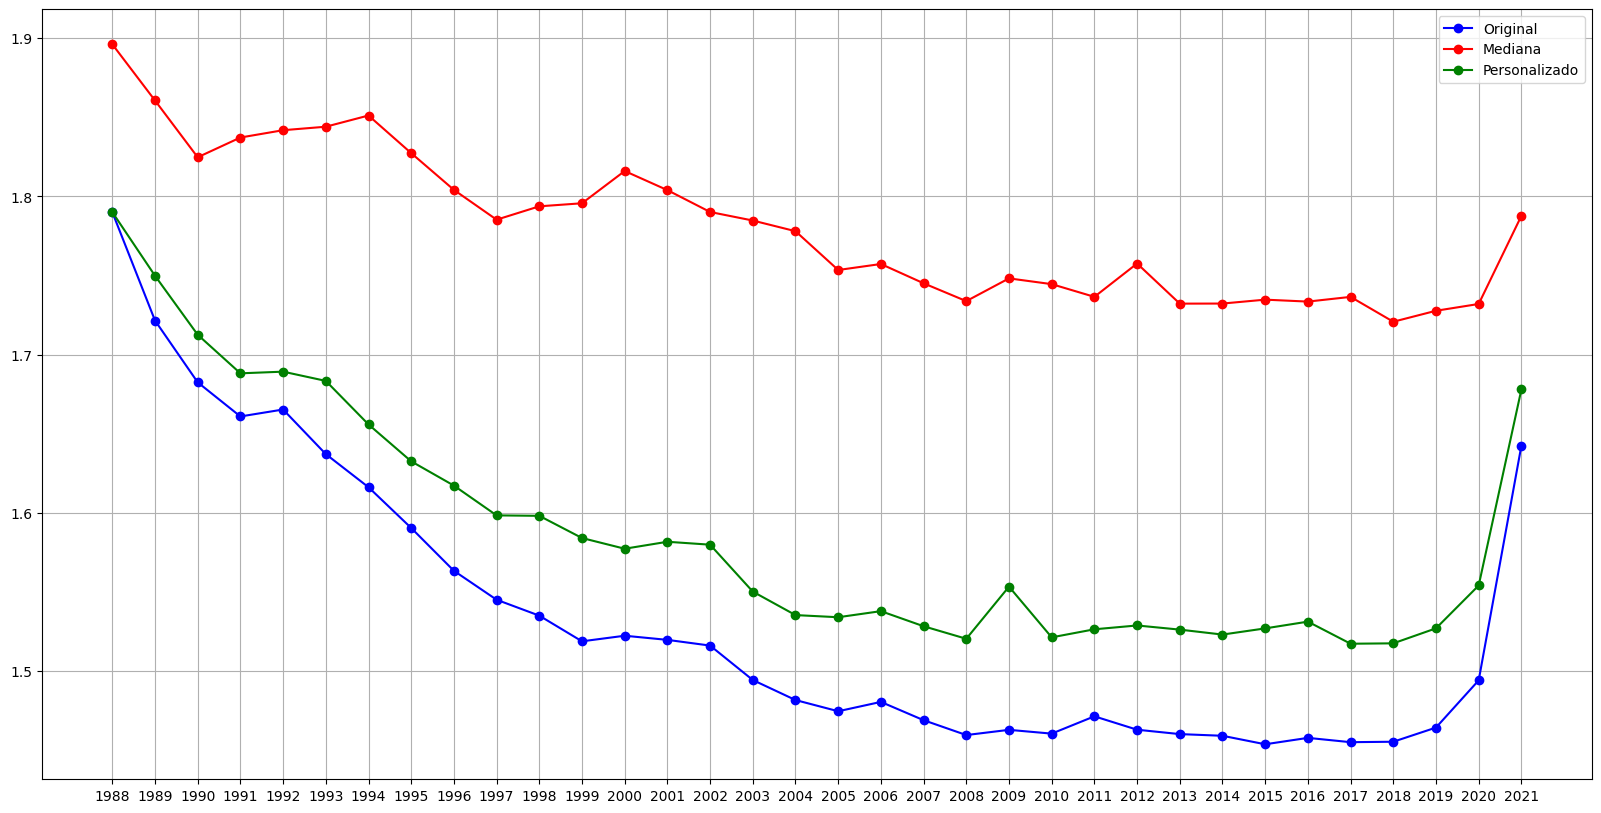

In [20]:
plt.figure(figsize=(20,10))
plt.xticks(df['Year'].unique())
plt.plot(result['Menor caminho medio'],'-ob', label='Original')
plt.plot(result_med['Menor caminho medio'],'-or', label='Mediana')
plt.plot(result_pers['Menor caminho medio'],'-og', label='Personalizado')
plt.legend()
plt.grid(True)
plt.show()

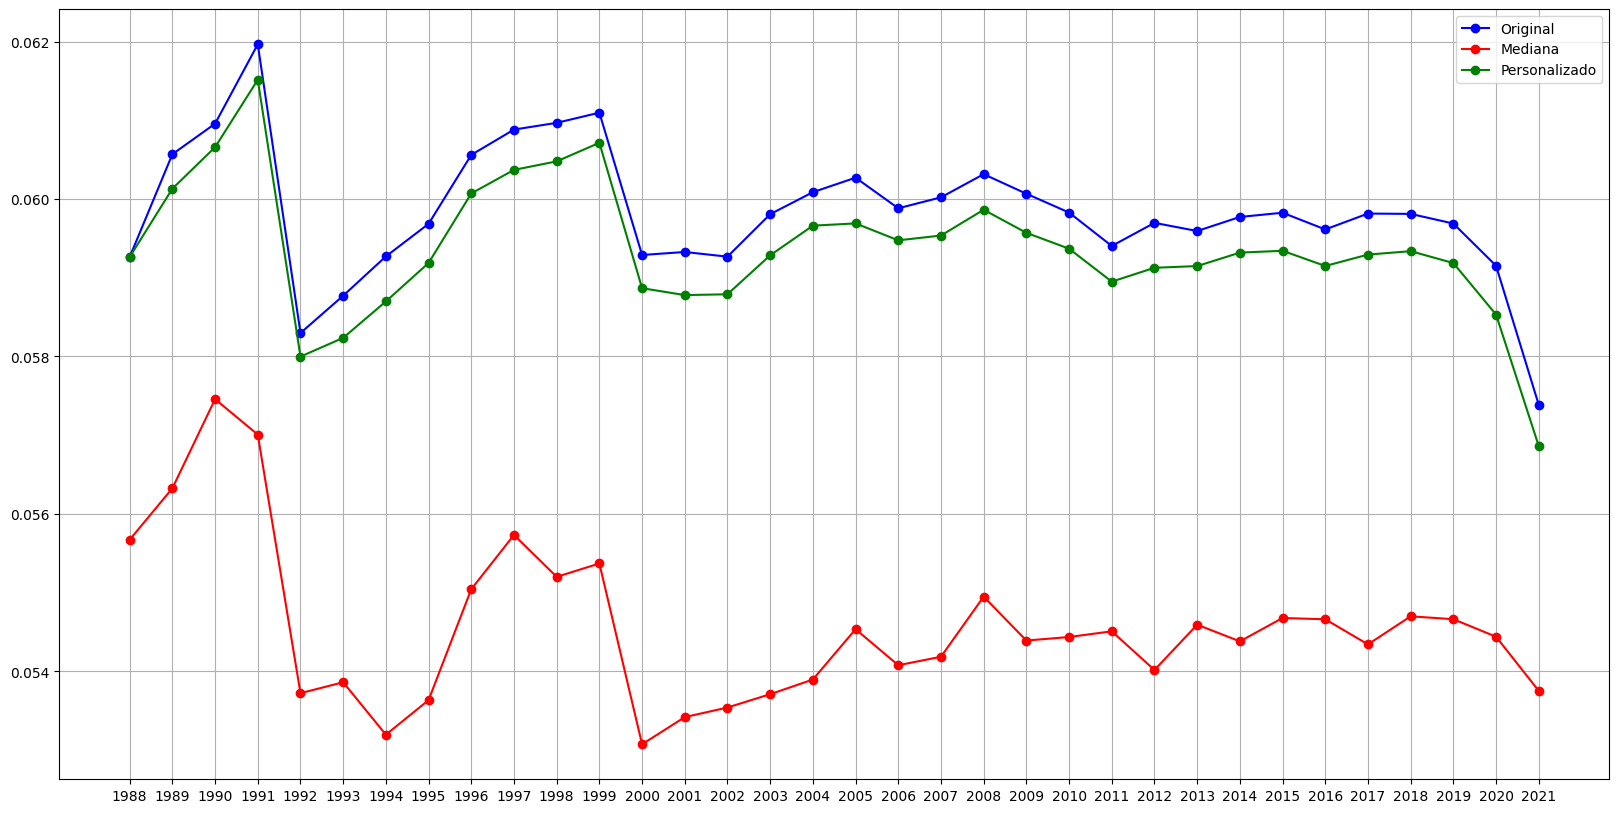

In [21]:
plt.figure(figsize=(20,10))
plt.xticks(df['Year'].unique())
plt.plot(result['Eigenvector centrality'],'-ob', label='Original')
plt.plot(result_med['Eigenvector centrality'],'-or', label='Mediana')
plt.plot(result_pers['Eigenvector centrality'],'-og', label='Personalizado')
plt.legend()
plt.grid(True)
plt.show()

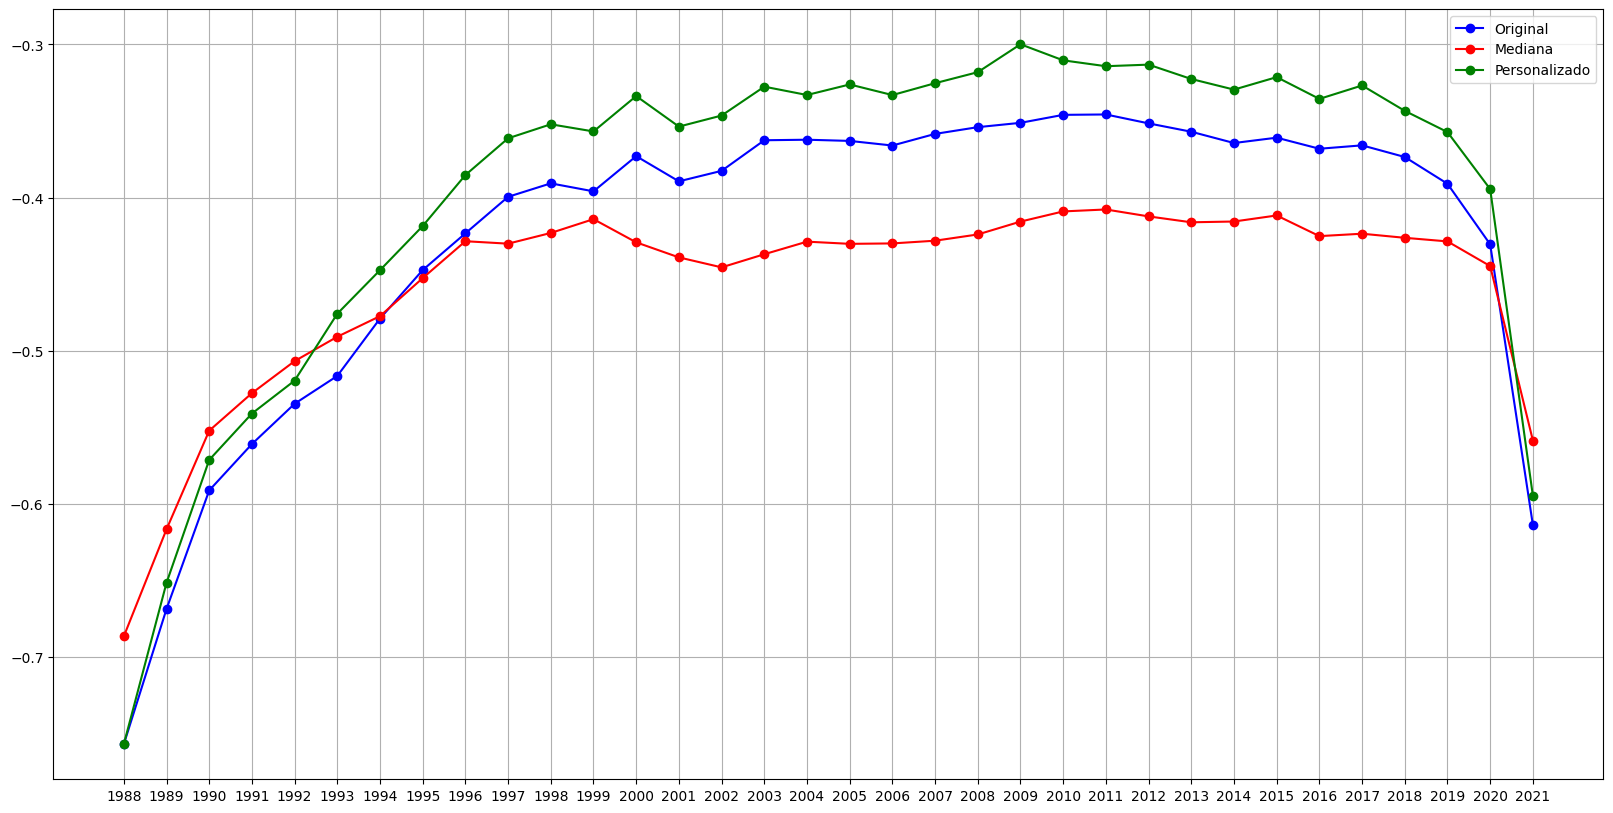

In [22]:
plt.figure(figsize=(20,10))
plt.xticks(df['Year'].unique())
plt.plot(result['Assortatividade'],'-ob', label='Original')
plt.plot(result_med['Assortatividade'],'-or', label='Mediana')
plt.plot(result_pers['Assortatividade'],'-og', label='Personalizado')
plt.legend()
plt.grid(True)
plt.show()

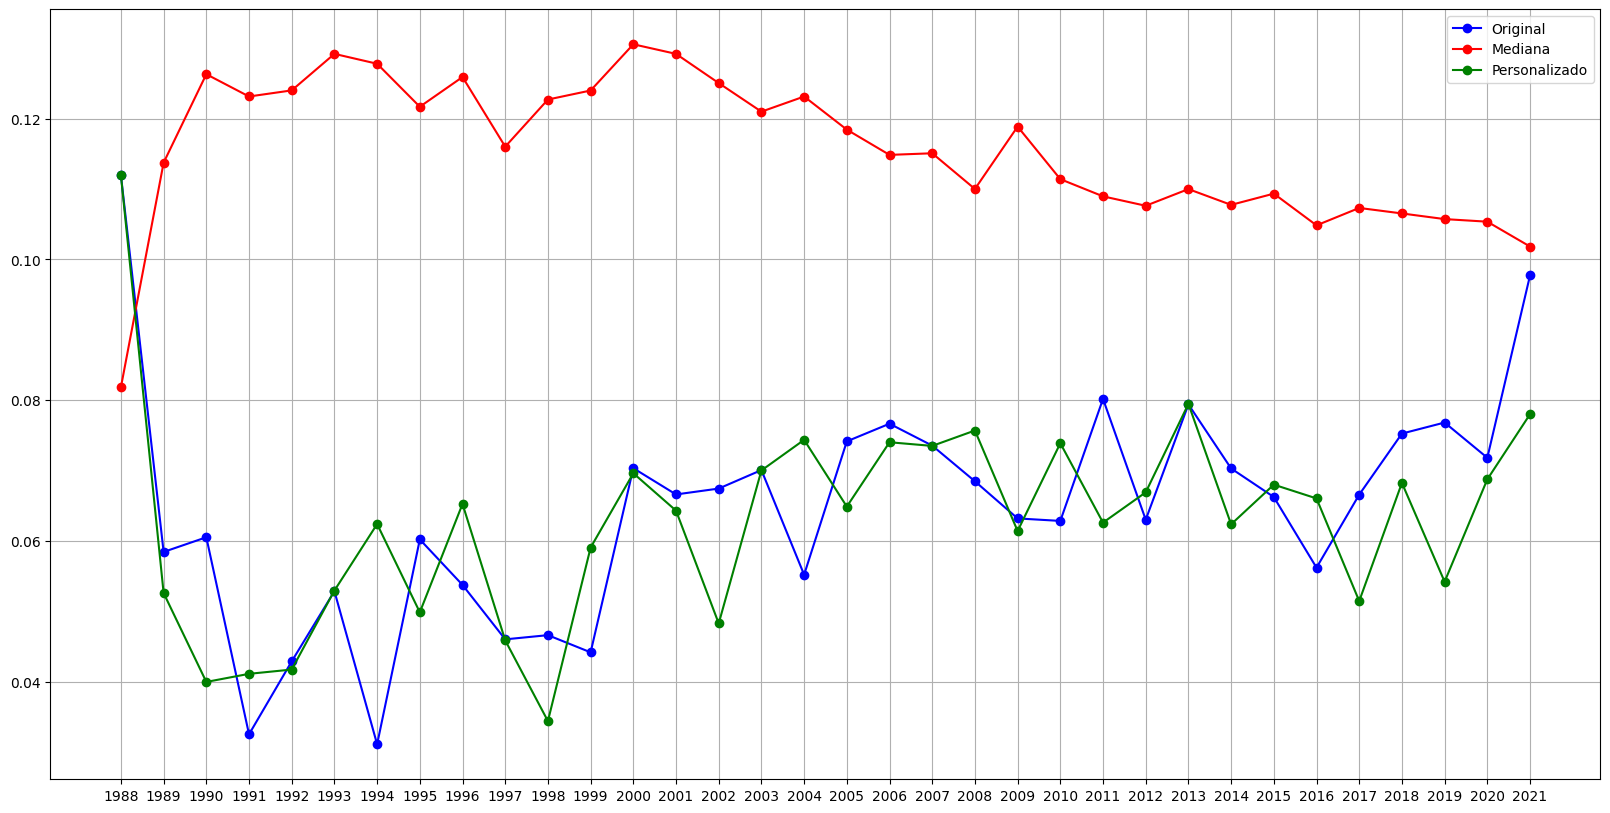

In [23]:
plt.figure(figsize=(20,10))
plt.xticks(df['Year'].unique())
plt.plot(result['Modularidade'],'-ob', label='Original')
plt.plot(result_med['Modularidade'],'-or', label='Mediana')
plt.plot(result_pers['Modularidade'],'-og', label='Personalizado')
plt.legend()
plt.grid(True)
plt.show()

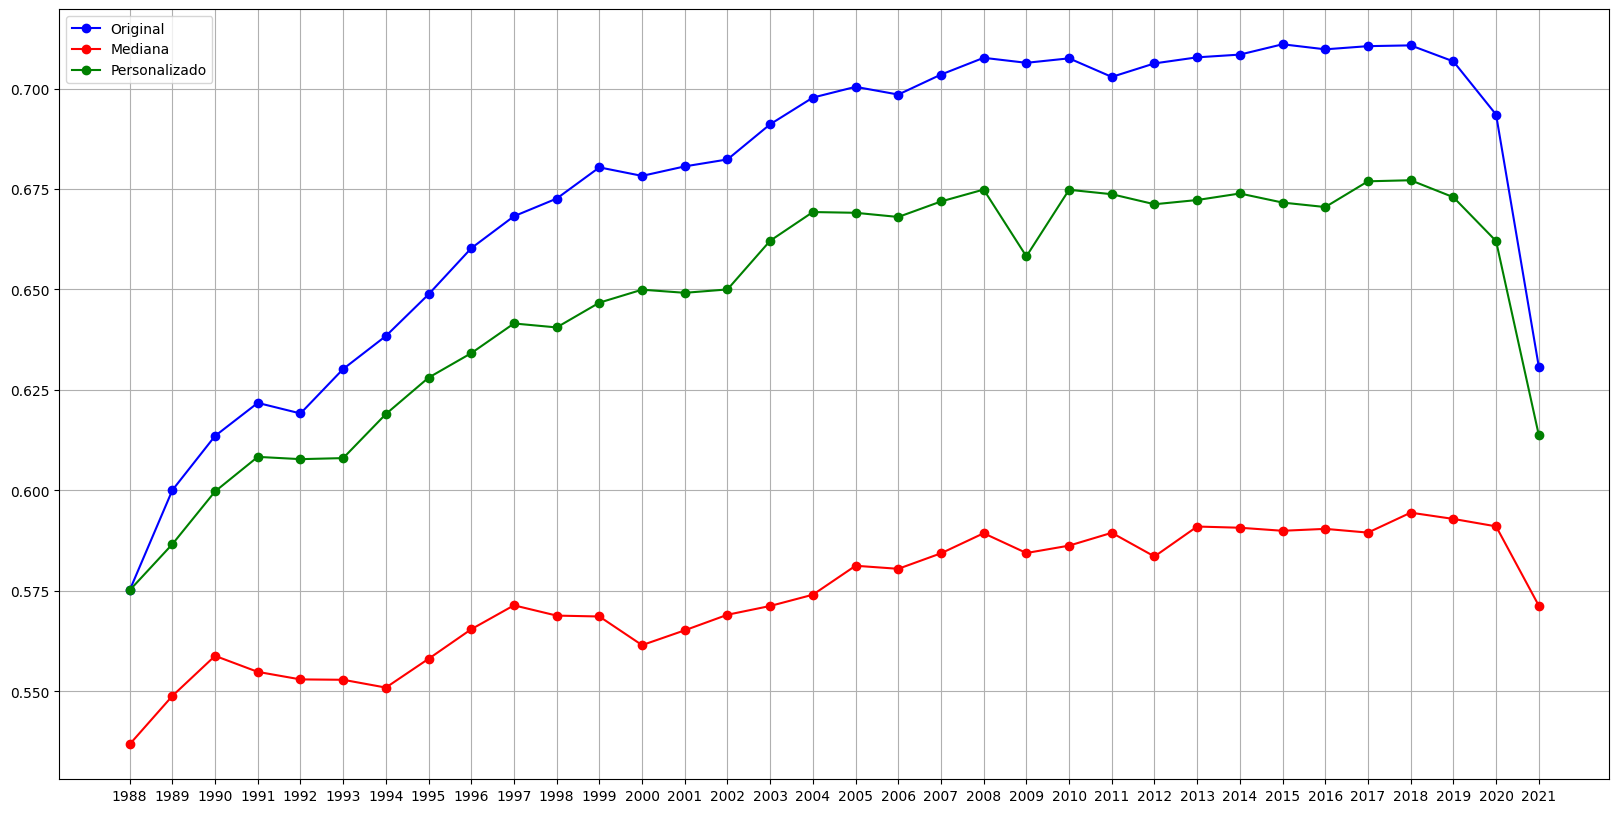

In [24]:
plt.figure(figsize=(20,10))
plt.xticks(df['Year'].unique())
plt.plot(result['Closeness centrality'],'-ob', label='Original')
plt.plot(result_med['Closeness centrality'],'-or', label='Mediana')
plt.plot(result_pers['Closeness centrality'],'-og', label='Personalizado')
plt.legend()
plt.grid(True)
plt.show()

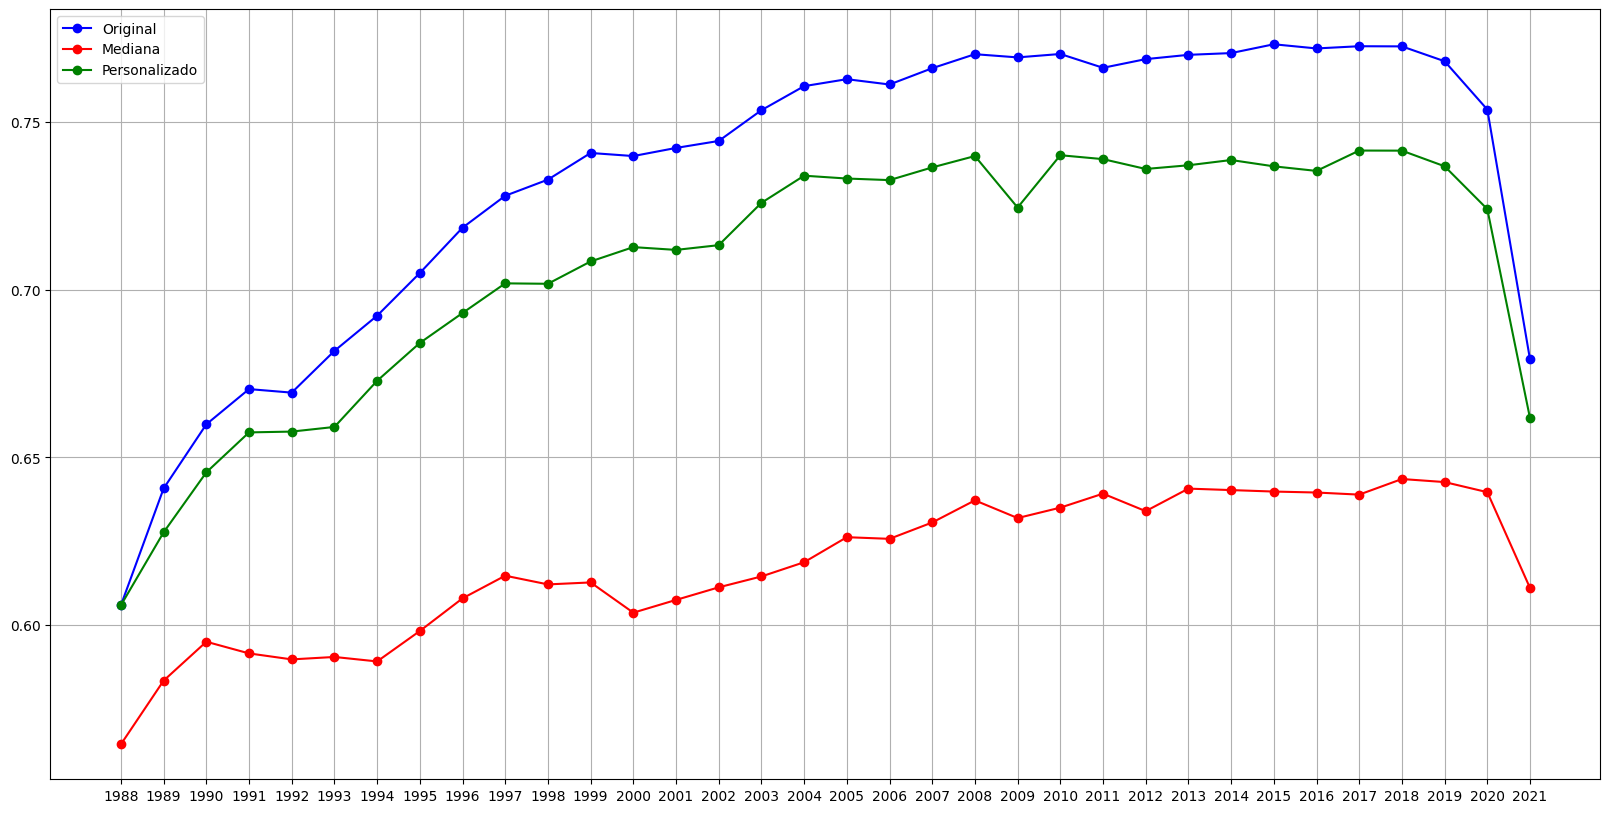

In [25]:
plt.figure(figsize=(20,10))
plt.xticks(df['Year'].unique())
plt.plot(result['Eficiencia Global'],'-ob', label='Original')
plt.plot(result_med['Eficiencia Global'],'-or', label='Mediana')
plt.plot(result_pers['Eficiencia Global'],'-og', label='Personalizado')
plt.legend()
plt.grid(True)
plt.show()

### Original

Como a rede original só é afetada por cortes completos nas conexões, extinguindo completamente o comércio, não é observado crises econômicas de menor escala ou que apenas diminuam a quantidade de comércio entre os países. Portanto não é possível ter uma análise muito profunda do problema.

De um modo geral, a rede irá crescer com o tempo e se tornar mais robusta, com uma queda drástica com a crise da covid-19.

### Mediana

Para o modelo da mediana, por outro lado, as redes apresentam quedas em determinados momentos que coincidem com as épocas em que houveram grandes crises mundiais, ou diversas crises em países diferentes, que ocorrem ao mesmo tempo ou sucessivamente, o que surte efeito nas medidas das redes estudadas. 

Em grande parte, as medidas diminuem em reação às crises, porém medidas como modularidade e menor caminho médio na rede tendem a aumentar, isso ocorre pois o menor caminho médio aumenta conforme são cortadas conexões da rede, significando a diminuição do comércio no período, já a modularidade representa uma diminuição do comércio pois indica que a rede está mais dividida em grupos, o que pode representar bem os blocos economicos deixando de comercializar entre si. As principais crises que são capturadas pelas medidas são listadas a seguir, surtindo nelas os efeitos comentados anteriormente.

- Crise econômica causada pela COVID-19, em 2020
- Recessão econômica de 2008
- Crises do começo dos anos 1990 (Suécia, Finlândia e Cuba)
- Crises no começo dos anos 2000 (Brasil, Argentina, Equador)

Outras crises podem ser identificadas nos gráficos, porém dado que são crises menores e isoladas elas não serão listadas aqui,
pois não é tão fácil confirmar que elas sejam a causa das alterações nas medidas da rede.

### Personalizada

Com o modelo personalizado tivemos resultados analiticos próximos ao modelo da mediana, mesmo com valores reais sendo diferentes, as tendências se mantiveram para as medidas.

No caso de modularidade tivemos resultados bem diferentes, com a modularidade diminuindo drasticamente conforme a rede ia crescendo, e aumentando em determinados momentos, condizendo com algumas das crises já observadas, como a de 2008 e a de 2020.

Vale ressaltar também que, por levar em consideração cada conexão individualmente para remoção ou adição, o modelo se torna mais robusto a crises locais.